# Обучение модели

## Импорт библиотек

In [ ]:
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import cv2
import numpy as np
import seaborn as sns

Подключаем Google Drive, чтобы иметь доступ к фотографиям для обучения модели.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подключаем самописные модули.

In [ ]:
from dataset import *
from model import predict
from metrics_and_loss_fn import iou_pytorch
import objects
from utils import (
                seed_everything,
                make_logical_masks_and_bboxes,
                draw_seg_masks,  draw_bboxes
                  )

## UNet с предобученными весами (Pretrained Backbones with UNet)
Это основанная на PyTorch библиотека Python с архитектурой UNet и множеством базовых компонентов (веса, архитектура модели и др.) для семантической сегментации изображений. Подгрузим эту библиотеку.

In [ ]:
!pip install pretrained-backbones-unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 12.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

Импортируем нужные модули. Попробуем обучить так.

In [ ]:
from backbones_unet.model.unet import Unet
from backbones_unet.utils.dataset import SemanticSegmentationDataset
from backbones_unet.model.losses import DiceLoss

Получаем список фотографий для обучения модели. Помним, что у нас названия файлов для карт растительности и для фотографий фрагментов поля совпадают.

In [ ]:
TRAIN_MASK_DIR = "/content/drive/MyDrive/plants_detection/dataset/mask"
TRAIN_IMG_DIR  = "/content/drive/MyDrive/plants_detection/dataset/img"

paths_all = os.listdir(TRAIN_IMG_DIR)

Из-за ограничений Google Colab  сократим обучающую выборку. В дальнейшем планируется сделать 42 раза обучение модели на разных выборках.

In [ ]:
SEED = 42
batch_size = 2
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Разбиваем данные и подготавливаем их для обучения модели.

In [ ]:
def make_dataloaders(paths):
  data_train, data_test = train_test_split(
                                  list(zip(paths, paths)),
                                  test_size=0.2,
                                  random_state=SEED
                                  )

  data_val, data_test = train_test_split(data_test, test_size=0.5,
                                    random_state=SEED
                                    )

  train = PlantsDataset(data_train, TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                        preprocessing =  train_img_preprocessing)
  val   = PlantsDataset(data_val, TRAIN_IMG_DIR, TRAIN_MASK_DIR)
  test  = PlantsDataset(data_test, TRAIN_IMG_DIR, TRAIN_MASK_DIR)

  print("Train:", len(train))
  print("Val:", len(val))
  print("Test:", len(test))

  train_loader = DataLoader(train, batch_size=batch_size,
                    shuffle=True, drop_last=True)
  val_loader = DataLoader(val, batch_size=batch_size,
                  shuffle=False, drop_last=True)
  test_loader = DataLoader(test,
                    batch_size=batch_size,
                  shuffle=False, drop_last=True)
  return train_loader, val_loader, test_loader

In [ ]:
model = Unet(
    backbone='convnext_base', # backbone network name
    in_channels=3,            # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=1,            # output channels (number of classes in your dataset)
)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


Training the contracting part and freezing the expanding part led to better
results compared to freezing the contracting part and fine-tuning the expanding
part

https://arxiv.org/pdf/2002.08438v1

Файнтюним только encoder, как сказано в статье.

## Extended Trainer -> Custom Trainer

In [ ]:
from backbones_unet.utils.trainer import Trainer

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        Y_pred = (Y_pred > 0).type(torch.uint8)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
def predict(model, data):
  global device
  model.eval()  # testing mode
  with torch.no_grad():
    data = data.to(device)
    pred = model(data)
    pred = (pred > 0).type(torch.uint8)
    return pred

In [ ]:
def visual_test_model(img_name):
  # создадим маску и bounding box-ы для тестового изображения
  dataset_tests = PlantsDataset([(img_name, img_name)], TRAIN_IMG_DIR, TRAIN_MASK_DIR)
  pred_mask = predict(trainer.model, dataset_tests[0][0].unsqueeze(0))
  res = pred_mask.squeeze(0, 1).cpu().numpy()

  real_img  = load_image(os.path.join(TRAIN_IMG_DIR, img_name))
  real_mask = load_image(os.path.join(TRAIN_MASK_DIR, img_name))
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

  ax1.imshow(real_img)
  ax1.set_title('Source image')

  ax2.imshow(real_mask)
  ax2.set_title('Real mask')

  ax3.imshow(res)
  ax3.set_title('Predicted mask')

  return res, real_img, real_mask

In [ ]:
def polygon_area_by_points(points):
  area = 0
  last = len(points) - 1
  for i in range(len(points)):
      area += points[last][0] * points[i][1] - points[last][1] * points[i][0]
      last = i
  return 0.5 * abs(area)

In [ ]:
def poly_distribution(mask):
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_NONE)
  areas = []
  for i, contour in enumerate(contours):
    #  area = polygon_area_by_points(contour.squeeze(1))
     area = cv2.contourArea(contour)
     areas += [[i, area]]
  areas_sorted = sorted(areas, key=lambda x: x[1])
  x, y = zip(*areas_sorted)
  sns.distplot(y)

In [ ]:
class CustomTrainer(Trainer):
  def __init__(
        self,
        model,
        criterion,
        optimizer,
        epochs,
        path_to_model,
        scaler=None,
        lr_scheduler=None,
        device=None
     ):
    super().__init__(
        model,
        criterion,
        optimizer,
        epochs,
        scaler,
        lr_scheduler,
        device
        )
    self.path_to_model = path_to_model
    self.best_vloss = float('inf')
    self.best_score = 0

  def fit(self, train_loader, val_loader):
        """
        Fit the model using the given loaders for the given number
        of epochs.

        Parameters
        ----------
        train_loader :
        val_loader :
        """
        # attributes
        self.train_losses_ = torch.zeros(self.epochs)
        self.val_losses_ = torch.zeros(self.epochs)
        # ---- train process ----
        for epoch in trange(1, self.epochs + 1,
                            desc='Traning Model on {} epochs'.format(self.epochs)):
            # train
            self._train_one_epoch(train_loader, epoch)
            # validate
            self._evaluate(val_loader, epoch)

            cur_score = score_model(self.model, iou_pytorch, val_loader)
            path_ending = f"_{self.val_losses_[epoch - 1]:.4f}_vloss{cur_score:.4f}_score.pth"

            print("Current model score:", cur_score)
            print("Best model score:", self.best_score)

            if self.val_losses_[epoch - 1] < self.best_vloss:
              self.best_vloss = self.val_losses_[epoch - 1]
              torch.save(self.model.state_dict(),
                         self.path_to_model + path_ending)

            if cur_score > self.best_score:
               self.best_score = cur_score
               torch.save(self.model.state_dict(),
                          self.path_to_model + path_ending)




In [ ]:
paths = paths_all[600:800]
train_loader, val_loader, test_loader = make_dataloaders(paths)

Train: 160
Val: 20
Test: 20


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/plants_detection/models/model_v0.3_0.5410_vloss0.0000_score.pth'))
model.to(device)
params = [p for p in model.decoder.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, 1e-4)

In [ ]:
trainer = CustomTrainer(
    model,                    # UNet model with pretrained backbone
    criterion=DiceLoss(),     # loss function for model convergence
    optimizer=optimizer,      # optimizer for regularization
    epochs=10,                # number of epochs for model training
    path_to_model='/content/drive/MyDrive/plants_detection/models/model_v0.4',
    device=device
)

In [ ]:
trainer.fit(train_loader, val_loader)

Epoch 1: 100%|██████████| 80/80 [03:44<00:00,  2.81s/ training-batch, loss=0.645]

Validation: 100%|██████████| 10/10 [00:15<00:00,  1.60s/ validating-batch, loss=0.73]


Current model score: 0.0
Best model score: 0


Epoch 2: 100%|██████████| 80/80 [00:16<00:00,  4.76 training-batch/s, loss=0.733]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.35 validating-batch/s, loss=0.686]


Current model score: 0.0
Best model score: 0


Epoch 3: 100%|██████████| 80/80 [00:17<00:00,  4.68 training-batch/s, loss=0.825]

Validation: 100%|██████████| 10/10 [00:00<00:00, 11.80 validating-batch/s, loss=0.681]


Current model score: 0.0
Best model score: 0


Epoch 4: 100%|██████████| 80/80 [00:17<00:00,  4.61 training-batch/s, loss=0.812]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.39 validating-batch/s, loss=0.66]


Current model score: 0.0
Best model score: 0


Epoch 5: 100%|██████████| 80/80 [00:17<00:00,  4.70 training-batch/s, loss=0.598]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.04 validating-batch/s, loss=0.642]


Current model score: 0.0
Best model score: 0


Epoch 6:  82%|████████▎ | 66/80 [00:14<00:03,  4.41 training-batch/s, loss=0.685]

Посмотрим, что предсказывает наша модель.

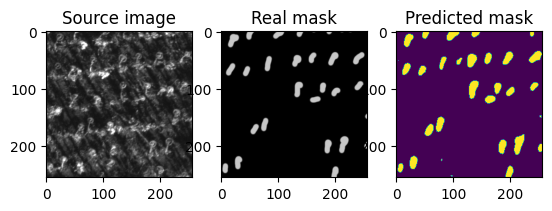

In [ ]:
pred_mask, _, _ = visual_test_model(paths_all[599])

<ipython-input-34-3b9f92fec1be>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


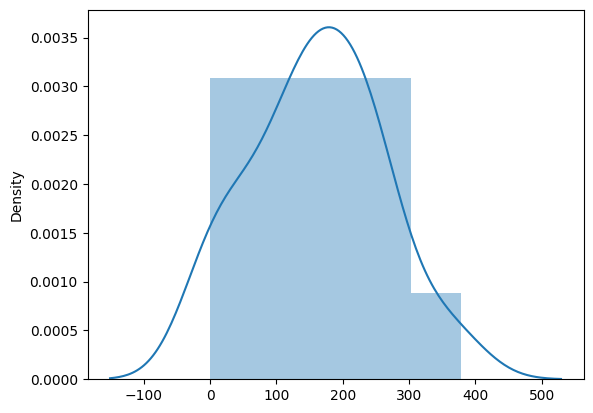

In [ ]:
poly_distribution(pred_mask)

In [ ]:
pred_mask.shape

(256, 256)

Избегаем копирования кода. Вынесем обучение модели на разных данных в отдельную функцию.

In [ ]:
def train_again(paths, v, model,
                path_to_model=None, params=None, optimizer=None):
  train_loader, val_loader, test_loader = make_dataloaders(paths)
  if path_to_model:
    model.load_state_dict(torch.load(path_to_model))
    model.to(device)
  if params is None:
    params = [p for p in model.decoder.parameters() if p.requires_grad]
  if optimizer is None:
    optimizer = torch.optim.AdamW(params, 1e-4)
  trainer = CustomTrainer(
      model,                    # UNet model with pretrained backbone
      criterion=DiceLoss(),     # loss function for model convergence
      optimizer=optimizer,      # optimizer for regularization
      epochs=10,                # number of epochs for model training
      path_to_model=f'/content/drive/MyDrive/plants_detection/models/model_v0.{v}',
      device=device
  )
  trainer.fit(train_loader, val_loader)

In [ ]:
train_again(paths=paths_all[800:1000],
            v=5,
            model=model,
            params=params,
            optimizer=optimizer
            )

Train: 160
Val: 20
Test: 20


Epoch 1: 100%|██████████| 80/80 [02:15<00:00,  1.70s/ training-batch, loss=0.834]

Validation: 100%|██████████| 10/10 [00:14<00:00,  1.46s/ validating-batch, loss=0.533]


Current model score: 0.0
Best model score: 0


Epoch 2: 100%|██████████| 80/80 [00:16<00:00,  4.72 training-batch/s, loss=0.536]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.60 validating-batch/s, loss=0.485]


Current model score: 0.0
Best model score: 0


Epoch 3: 100%|██████████| 80/80 [00:17<00:00,  4.53 training-batch/s, loss=0.861]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.73 validating-batch/s, loss=0.487]


Current model score: 0.0
Best model score: 0


Epoch 4: 100%|██████████| 80/80 [00:17<00:00,  4.52 training-batch/s, loss=0.499]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.79 validating-batch/s, loss=0.45]


Current model score: 0.0
Best model score: 0


Epoch 5: 100%|██████████| 80/80 [00:17<00:00,  4.60 training-batch/s, loss=0.542]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.20 validating-batch/s, loss=0.425]


Current model score: 0.0
Best model score: 0


Epoch 6: 100%|██████████| 80/80 [00:18<00:00,  4.37 training-batch/s, loss=0.785]

Validation: 100%|██████████| 10/10 [00:00<00:00, 11.02 validating-batch/s, loss=0.408]


Current model score: 0.0
Best model score: 0


Epoch 7: 100%|██████████| 80/80 [00:17<00:00,  4.45 training-batch/s, loss=0.662]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.82 validating-batch/s, loss=0.388]


Current model score: 0.0
Best model score: 0


Epoch 8: 100%|██████████| 80/80 [00:17<00:00,  4.49 training-batch/s, loss=0.398]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.77 validating-batch/s, loss=0.367]


Current model score: 0.0
Best model score: 0


Epoch 9: 100%|██████████| 80/80 [00:18<00:00,  4.44 training-batch/s, loss=0.717]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.47 validating-batch/s, loss=0.366]


Current model score: 0.0
Best model score: 0


Epoch 10: 100%|██████████| 80/80 [00:17<00:00,  4.52 training-batch/s, loss=0.331]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.14 validating-batch/s, loss=0.344]


Current model score: 0.0
Best model score: 0


Traning Model on 10 epochs: 100%|██████████| 10/10 [05:38<00:00, 33.84s/it]


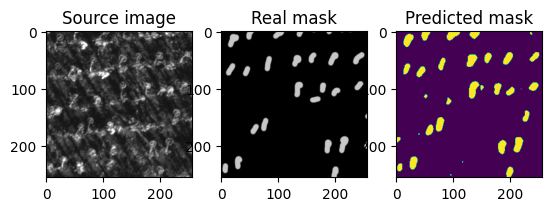

In [ ]:
pred_mask, _, _ = visual_test_model(paths_all[599])

<ipython-input-34-3b9f92fec1be>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


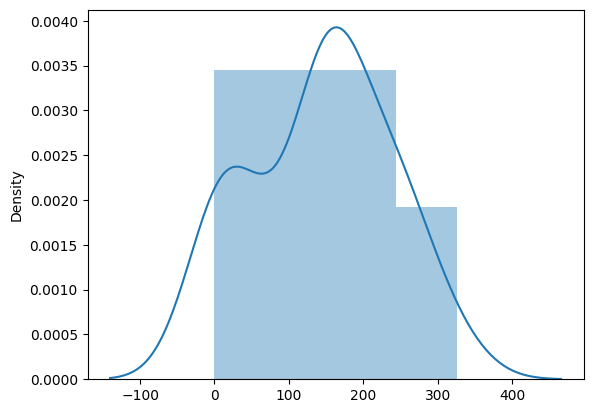

In [ ]:
poly_distribution(pred_mask)

In [ ]:
torch.save(model.state_dict(),
                         "/content/model_v0.5.pth")

In [ ]:
train_again(paths=paths_all[1000:1200],
            v=6,
            model=model,
            params=params,
            optimizer=optimizer
            )

Train: 160
Val: 20
Test: 20


Epoch 1: 100%|██████████| 80/80 [02:18<00:00,  1.73s/ training-batch, loss=0.389]

Validation: 100%|██████████| 10/10 [00:16<00:00,  1.62s/ validating-batch, loss=0.394]


Current model score: 0.0
Best model score: 0


Epoch 2: 100%|██████████| 80/80 [00:17<00:00,  4.62 training-batch/s, loss=0.602]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.96 validating-batch/s, loss=0.383]


Current model score: 0.0
Best model score: 0


Epoch 3: 100%|██████████| 80/80 [00:17<00:00,  4.66 training-batch/s, loss=0.621]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.25 validating-batch/s, loss=0.3]


Current model score: 0.0
Best model score: 0


Epoch 4: 100%|██████████| 80/80 [00:17<00:00,  4.57 training-batch/s, loss=0.209]

Validation: 100%|██████████| 10/10 [00:00<00:00, 11.32 validating-batch/s, loss=0.302]


Current model score: 0.0
Best model score: 0


Epoch 5: 100%|██████████| 80/80 [00:17<00:00,  4.60 training-batch/s, loss=0.361]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.31 validating-batch/s, loss=0.272]


Current model score: 0.0
Best model score: 0


Epoch 6: 100%|██████████| 80/80 [00:17<00:00,  4.65 training-batch/s, loss=0.29]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.07 validating-batch/s, loss=0.245]


Current model score: 0.0
Best model score: 0


Epoch 7: 100%|██████████| 80/80 [00:18<00:00,  4.41 training-batch/s, loss=0.285]

Validation: 100%|██████████| 10/10 [00:00<00:00, 10.86 validating-batch/s, loss=0.241]


Current model score: 0.0
Best model score: 0


Epoch 8: 100%|██████████| 80/80 [00:16<00:00,  4.75 training-batch/s, loss=0.648]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.83 validating-batch/s, loss=0.229]


Current model score: 0.0
Best model score: 0


Epoch 9: 100%|██████████| 80/80 [00:16<00:00,  4.78 training-batch/s, loss=0.343]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.09 validating-batch/s, loss=0.22]


Current model score: 0.0
Best model score: 0


Epoch 10: 100%|██████████| 80/80 [00:16<00:00,  4.74 training-batch/s, loss=0.259]

Validation: 100%|██████████| 10/10 [00:00<00:00, 12.44 validating-batch/s, loss=0.205]


Current model score: 0.0
Best model score: 0


Traning Model on 10 epochs: 100%|██████████| 10/10 [05:38<00:00, 33.87s/it]


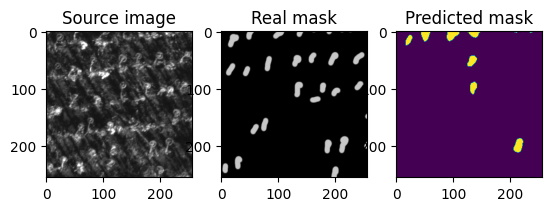

In [ ]:
pred_mask, _, _ = visual_test_model(paths_all[599])


<ipython-input-34-3b9f92fec1be>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


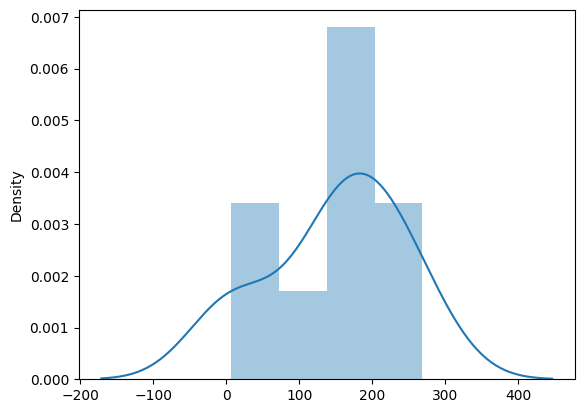

In [ ]:
poly_distribution(pred_mask)

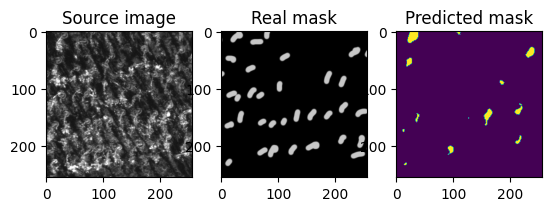

In [ ]:
pred_mask, _, _ = visual_test_model(paths_all[200])


Предсказание стало хуже, чем было. Попробуем обучить модель ещё раз, если результат не улучшится - оставим предыдущую.

In [ ]:
train_again(paths=paths_all[1200:1400],
            v=7,
            model=model
            )

Train: 160
Val: 20
Test: 20


Epoch 1: 100%|██████████| 80/80 [02:11<00:00,  1.64s/ training-batch, loss=0.714]

Validation: 100%|██████████| 10/10 [00:16<00:00,  1.65s/ validating-batch, loss=0.252]


Current model score: 0.0
Best model score: 0


Epoch 2: 100%|██████████| 80/80 [00:16<00:00,  4.86 training-batch/s, loss=0.51]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.18 validating-batch/s, loss=0.193]


Current model score: 0.0
Best model score: 0


Epoch 3: 100%|██████████| 80/80 [00:16<00:00,  4.82 training-batch/s, loss=0.159]

Validation: 100%|██████████| 10/10 [00:00<00:00, 11.87 validating-batch/s, loss=0.175]


Current model score: 0.0
Best model score: 0


Epoch 4: 100%|██████████| 80/80 [00:16<00:00,  4.86 training-batch/s, loss=0.48]

Validation: 100%|██████████| 10/10 [00:00<00:00, 13.12 validating-batch/s, loss=0.173]


Current model score: 0.0
Best model score: 0


Epoch 5: 100%|██████████| 80/80 [00:16<00:00,  4.87 training-batch/s, loss=0.551]

Traning Model on 10 epochs:  50%|█████     | 5/10 [03:46<02:30, 30.18s/it]

Current model score: 0.0
Best model score: 0



Epoch 6: 100%|██████████| 80/80 [00:16<00:00,  4.82 training-batch/s, loss=0.589]

Validation: 100%|██████████| 10/10 [00:00<00:00, 11.20 validating-batch/s, loss=0.154]


Current model score: 0.0
Best model score: 0


Epoch 7: 100%|██████████| 80/80 [00:21<00:00,  3.75 training-batch/s, loss=0.508]

Validation: 100%|██████████| 10/10 [00:01<00:00,  7.34 validating-batch/s, loss=0.149]


Current model score: 0.0
Best model score: 0


Epoch 8: 100%|██████████| 80/80 [00:17<00:00,  4.66 training-batch/s, loss=0.254]

Validation:  20%|██        | 2/10 [00:00<00:00, 10.58 validating-batch/s, loss=0.166]


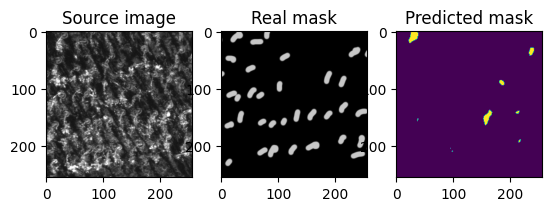

In [ ]:
pred_mask, _, _ = visual_test_model(paths_all[200])


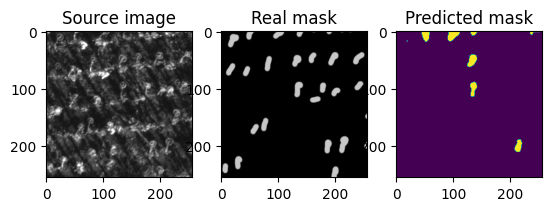

In [ ]:
pred_mask, _, _ = visual_test_model(paths_all[599])


Здорово, что форма подсолнухов стала четче, но нейронная сеть теперь видит только хорошо различимые подсолнухи. Придется вернуться к НС v0.4, v0.5, а также попробовать нейронные сети более ранних этапов обучения. Протестируем, насколько хорошо они определяют подсолнухи. Но это будет в следующем ноутбуке.